# SBA Loan Analysis

# Modeling - Part 4 - CatBoost

## 1. Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, f1_score, matthews_corrcoef, confusion_matrix

from library.preprocessing import processing_pipeline
from library.modeling import (createModel, createClassificationMetrics,
                             runGridSearchAnalysis, createConfusionMatrix, createFeatureImportanceChart)

## 2. Previewing Data

In [2]:
sba_loans = pd.read_csv('./../data/processed/sba_national_processed_final.csv')

pd.set_option('display.max_columns', None)

In [3]:
sba_loans.head()

,Term,NoEmp,CreateJob,RetainedJob,DisbursementGross,GrAppv,SBA_Appv,NAICS_sectors,unemployment_rate,gdp_growth,gdp_annual_change,inflation_rate,inf_rate_annual_chg,NewExist_existing_business,NewExist_new_business,UrbanRural_rural,UrbanRural_urban,isFranchise_not_franchise,RevLineCr_v2_N,RevLineCr_v2_Y,LowDoc_v2_N,LowDoc_v2_Y,MIS_Status_v2_default,state_top10
0,84,4,0,0,60000.0,60000.0,48000.0,45,3.5,4.4472,0.67,2.3377,-0.59,0,1,0,0,1,1,0,0,1,0,0
1,60,2,0,0,40000.0,40000.0,32000.0,72,3.5,4.4472,0.67,2.3377,-0.59,0,1,0,0,1,1,0,0,1,0,0
2,180,7,0,0,287000.0,287000.0,215250.0,62,3.5,4.4472,0.67,2.3377,-0.59,1,0,0,0,1,1,0,1,0,0,0
3,60,2,0,0,35000.0,35000.0,28000.0,0,4.1,4.4472,0.67,2.3377,-0.59,1,0,0,0,1,1,0,0,1,0,0
4,240,14,7,7,229000.0,229000.0,229000.0,0,4.8,4.4472,0.67,2.3377,-0.59,1,0,0,0,1,1,0,1,0,0,1


In [4]:
target = 'MIS_Status_v2_default'
features = sba_loans.drop(columns='MIS_Status_v2_default', axis=1).columns

## 3. CatBoost Classifier with Standard Scaler

In [5]:
X_train_ss, X_test_ss, y_train_ss, y_test_ss = processing_pipeline(sba_loans, target)

### A. Simple CatBoost Model

In [6]:
cat_ss_mod1 = CatBoostClassifier(random_state=42, verbose=0)
y_pred = createModel(cat_ss_mod1, X_train_ss, y_train_ss, X_test_ss)

### B. Evaluation Metrics

In [7]:
acc_score, cr, f1, mcc = createClassificationMetrics(y_pred, y_test_ss)

**Accuracy Score**

In [8]:
print(acc_score)

0.9498872994264546


**Classification Report**

In [9]:
print(cr)

              precision    recall  f1-score   support

        paid       0.97      0.97      0.97    223642
     default       0.84      0.87      0.85     45212

    accuracy                           0.95    268854
   macro avg       0.91      0.92      0.91    268854
weighted avg       0.95      0.95      0.95    268854



**F1 Score**

In [10]:
print(f1)

0.8538957870194653


**Matthew's Correlation Coefficient**

In [11]:
print(mcc)

0.8238930327835728


### Finding Best CatBoost Model with Standard Scaler

In [12]:
param_grid = {
    'learning_rate': [0.03, 0.1],
    'iterations': [500, 1000],
    'l2_leaf_reg': [1.0, 3.0],
    'depth': [3,6]   
}

In [13]:
cbc = CatBoostClassifier(random_state=42, verbose=0)
cbc_ss_best_params, y_pred = runGridSearchAnalysis(cbc, param_grid, X_train_ss, y_train_ss, X_test_ss)

In [14]:
print(cbc_ss_best_params)

{'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 3.0, 'learning_rate': 0.1}


In [15]:
acc_score, cr, f1, mcc = createClassificationMetrics(y_pred, y_test_ss)
print('Accuracy Score: {}'.format(acc_score))
print('Matthew\'s Correlation Coefficient: {}'.format(mcc))
print('F1 Score: {}'.format(f1))
print('Classification Report: \n{}'.format(cr))

Accuracy Score: 0.9491173648151041
Matthew's Correlation Coefficient: 0.8206916936738459
F1 Score: 0.8510128512306686
Classification Report: 
              precision    recall  f1-score   support

        paid       0.97      0.96      0.97    224037
     default       0.83      0.87      0.85     44817

    accuracy                           0.95    268854
   macro avg       0.90      0.92      0.91    268854
weighted avg       0.95      0.95      0.95    268854



### D. Confusion Matrix

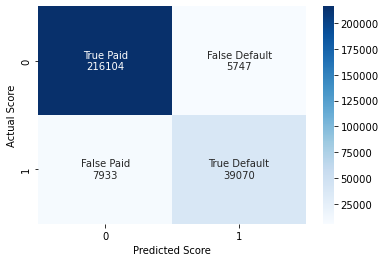

In [16]:
cbc_ss_fp = createConfusionMatrix(y_test_ss, y_pred)

### E. Feature Importance with Best Params

0:	learn: 0.5891192	total: 51.3ms	remaining: 51.3s
1:	learn: 0.5115581	total: 107ms	remaining: 53.2s
2:	learn: 0.4547759	total: 167ms	remaining: 55.6s
3:	learn: 0.4112727	total: 223ms	remaining: 55.6s
4:	learn: 0.3838239	total: 272ms	remaining: 54.1s
5:	learn: 0.3583699	total: 318ms	remaining: 52.7s
6:	learn: 0.3414740	total: 359ms	remaining: 50.9s
7:	learn: 0.3248483	total: 402ms	remaining: 49.9s
8:	learn: 0.3147457	total: 441ms	remaining: 48.6s
9:	learn: 0.3028447	total: 489ms	remaining: 48.4s
10:	learn: 0.2939229	total: 532ms	remaining: 47.8s
11:	learn: 0.2866692	total: 573ms	remaining: 47.2s
12:	learn: 0.2765952	total: 621ms	remaining: 47.2s
13:	learn: 0.2716714	total: 666ms	remaining: 46.9s
14:	learn: 0.2673750	total: 721ms	remaining: 47.4s
15:	learn: 0.2636391	total: 761ms	remaining: 46.8s
16:	learn: 0.2585425	total: 812ms	remaining: 46.9s
17:	learn: 0.2554375	total: 865ms	remaining: 47.2s
18:	learn: 0.2527816	total: 913ms	remaining: 47.1s
19:	learn: 0.2501683	total: 964ms	remain

162:	learn: 0.1604111	total: 7.62s	remaining: 39.2s
163:	learn: 0.1602914	total: 7.67s	remaining: 39.1s
164:	learn: 0.1601168	total: 7.71s	remaining: 39s
165:	learn: 0.1599665	total: 7.75s	remaining: 39s
166:	learn: 0.1598434	total: 7.79s	remaining: 38.9s
167:	learn: 0.1597152	total: 7.83s	remaining: 38.8s
168:	learn: 0.1595353	total: 7.89s	remaining: 38.8s
169:	learn: 0.1594270	total: 7.94s	remaining: 38.8s
170:	learn: 0.1593016	total: 7.98s	remaining: 38.7s
171:	learn: 0.1591043	total: 8.07s	remaining: 38.8s
172:	learn: 0.1589720	total: 8.15s	remaining: 39s
173:	learn: 0.1588674	total: 8.21s	remaining: 39s
174:	learn: 0.1587072	total: 8.3s	remaining: 39.1s
175:	learn: 0.1585863	total: 8.36s	remaining: 39.1s
176:	learn: 0.1584042	total: 8.4s	remaining: 39.1s
177:	learn: 0.1583039	total: 8.45s	remaining: 39s
178:	learn: 0.1581569	total: 8.49s	remaining: 39s
179:	learn: 0.1579941	total: 8.55s	remaining: 38.9s
180:	learn: 0.1578889	total: 8.62s	remaining: 39s
181:	learn: 0.1577899	total:

322:	learn: 0.1466440	total: 15.6s	remaining: 32.7s
323:	learn: 0.1465943	total: 15.6s	remaining: 32.6s
324:	learn: 0.1465410	total: 15.7s	remaining: 32.6s
325:	learn: 0.1464871	total: 15.7s	remaining: 32.6s
326:	learn: 0.1464272	total: 15.8s	remaining: 32.5s
327:	learn: 0.1463711	total: 15.9s	remaining: 32.5s
328:	learn: 0.1463142	total: 15.9s	remaining: 32.5s
329:	learn: 0.1462568	total: 16s	remaining: 32.4s
330:	learn: 0.1462228	total: 16s	remaining: 32.4s
331:	learn: 0.1461948	total: 16.1s	remaining: 32.3s
332:	learn: 0.1461546	total: 16.1s	remaining: 32.3s
333:	learn: 0.1460576	total: 16.2s	remaining: 32.4s
334:	learn: 0.1460013	total: 16.3s	remaining: 32.3s
335:	learn: 0.1459536	total: 16.3s	remaining: 32.3s
336:	learn: 0.1458889	total: 16.4s	remaining: 32.3s
337:	learn: 0.1458279	total: 16.4s	remaining: 32.2s
338:	learn: 0.1457776	total: 16.5s	remaining: 32.2s
339:	learn: 0.1457252	total: 16.5s	remaining: 32.1s
340:	learn: 0.1456694	total: 16.6s	remaining: 32.1s
341:	learn: 0.14

482:	learn: 0.1401214	total: 26.7s	remaining: 28.6s
483:	learn: 0.1400919	total: 26.7s	remaining: 28.5s
484:	learn: 0.1400806	total: 26.8s	remaining: 28.5s
485:	learn: 0.1400321	total: 27s	remaining: 28.6s
486:	learn: 0.1400061	total: 27.1s	remaining: 28.6s
487:	learn: 0.1399810	total: 27.2s	remaining: 28.5s
488:	learn: 0.1399610	total: 27.3s	remaining: 28.5s
489:	learn: 0.1399374	total: 27.3s	remaining: 28.5s
490:	learn: 0.1399080	total: 27.4s	remaining: 28.4s
491:	learn: 0.1398896	total: 27.5s	remaining: 28.4s
492:	learn: 0.1398671	total: 27.5s	remaining: 28.3s
493:	learn: 0.1398511	total: 27.6s	remaining: 28.3s
494:	learn: 0.1398296	total: 27.7s	remaining: 28.3s
495:	learn: 0.1398108	total: 27.8s	remaining: 28.2s
496:	learn: 0.1397864	total: 27.8s	remaining: 28.2s
497:	learn: 0.1397573	total: 27.9s	remaining: 28.1s
498:	learn: 0.1397261	total: 27.9s	remaining: 28.1s
499:	learn: 0.1397126	total: 28s	remaining: 28s
500:	learn: 0.1396909	total: 28s	remaining: 27.9s
501:	learn: 0.139641

642:	learn: 0.1361536	total: 34.9s	remaining: 19.4s
643:	learn: 0.1361346	total: 35s	remaining: 19.3s
644:	learn: 0.1361138	total: 35s	remaining: 19.3s
645:	learn: 0.1361018	total: 35.1s	remaining: 19.2s
646:	learn: 0.1360776	total: 35.1s	remaining: 19.2s
647:	learn: 0.1360582	total: 35.2s	remaining: 19.1s
648:	learn: 0.1360247	total: 35.2s	remaining: 19s
649:	learn: 0.1360110	total: 35.2s	remaining: 19s
650:	learn: 0.1359785	total: 35.3s	remaining: 18.9s
651:	learn: 0.1359496	total: 35.3s	remaining: 18.9s
652:	learn: 0.1359336	total: 35.4s	remaining: 18.8s
653:	learn: 0.1359110	total: 35.4s	remaining: 18.7s
654:	learn: 0.1358920	total: 35.5s	remaining: 18.7s
655:	learn: 0.1358784	total: 35.5s	remaining: 18.6s
656:	learn: 0.1358659	total: 35.5s	remaining: 18.6s
657:	learn: 0.1358386	total: 35.6s	remaining: 18.5s
658:	learn: 0.1358169	total: 35.6s	remaining: 18.4s
659:	learn: 0.1358024	total: 35.7s	remaining: 18.4s
660:	learn: 0.1357747	total: 35.7s	remaining: 18.3s
661:	learn: 0.135758

803:	learn: 0.1331621	total: 43.2s	remaining: 10.5s
804:	learn: 0.1331515	total: 43.2s	remaining: 10.5s
805:	learn: 0.1331391	total: 43.3s	remaining: 10.4s
806:	learn: 0.1331170	total: 43.3s	remaining: 10.4s
807:	learn: 0.1331088	total: 43.4s	remaining: 10.3s
808:	learn: 0.1330858	total: 43.4s	remaining: 10.2s
809:	learn: 0.1330725	total: 43.5s	remaining: 10.2s
810:	learn: 0.1330453	total: 43.5s	remaining: 10.1s
811:	learn: 0.1330251	total: 43.6s	remaining: 10.1s
812:	learn: 0.1330081	total: 43.6s	remaining: 10s
813:	learn: 0.1329930	total: 43.7s	remaining: 9.98s
814:	learn: 0.1329799	total: 43.8s	remaining: 9.94s
815:	learn: 0.1329546	total: 43.9s	remaining: 9.89s
816:	learn: 0.1329446	total: 43.9s	remaining: 9.84s
817:	learn: 0.1329323	total: 44s	remaining: 9.78s
818:	learn: 0.1329188	total: 44s	remaining: 9.73s
819:	learn: 0.1329063	total: 44.1s	remaining: 9.67s
820:	learn: 0.1328946	total: 44.1s	remaining: 9.62s
821:	learn: 0.1328767	total: 44.2s	remaining: 9.56s
822:	learn: 0.1328

965:	learn: 0.1307882	total: 51.8s	remaining: 1.82s
966:	learn: 0.1307788	total: 51.9s	remaining: 1.77s
967:	learn: 0.1307661	total: 51.9s	remaining: 1.72s
968:	learn: 0.1307572	total: 52s	remaining: 1.66s
969:	learn: 0.1307320	total: 52s	remaining: 1.61s
970:	learn: 0.1307179	total: 52s	remaining: 1.55s
971:	learn: 0.1307076	total: 52.1s	remaining: 1.5s
972:	learn: 0.1306966	total: 52.1s	remaining: 1.45s
973:	learn: 0.1306889	total: 52.2s	remaining: 1.39s
974:	learn: 0.1306660	total: 52.2s	remaining: 1.34s
975:	learn: 0.1306488	total: 52.3s	remaining: 1.28s
976:	learn: 0.1306348	total: 52.3s	remaining: 1.23s
977:	learn: 0.1306251	total: 52.4s	remaining: 1.18s
978:	learn: 0.1306051	total: 52.5s	remaining: 1.13s
979:	learn: 0.1305940	total: 52.5s	remaining: 1.07s
980:	learn: 0.1305874	total: 52.6s	remaining: 1.02s
981:	learn: 0.1305742	total: 52.6s	remaining: 965ms
982:	learn: 0.1305650	total: 52.7s	remaining: 911ms
983:	learn: 0.1305537	total: 52.8s	remaining: 858ms
984:	learn: 0.13054

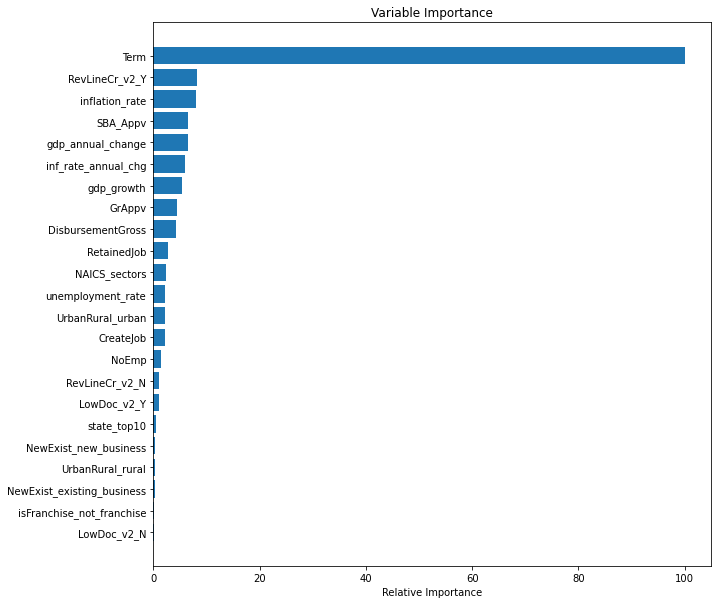

In [17]:
createFeatureImportanceChart(CatBoostClassifier, cbc_ss_best_params, features, X_train_ss, y_train_ss)

## 4. CatBoost Classifier with Robust Scaler

In [18]:
X_train_rs, X_test_rs, y_train_rs, y_test_rs = processing_pipeline(sba_loans, target, scaler='Robust')

### A. Simple CatBoost Model

In [20]:
cbc_rs_mod1 = CatBoostClassifier(random_state=42, verbose=0)
y_pred = createModel(cbc_rs_mod1, X_train_rs, y_train_rs, X_test_rs)

### B. Evaluation Metrics

In [21]:
acc_score, cr, f1, mcc = createClassificationMetrics(y_pred, y_test_ss)

**Accuracy Score**

In [22]:
print(acc_score)

0.9498612629903219


**Classification Report**

In [23]:
print(cr)

              precision    recall  f1-score   support

        paid       0.97      0.97      0.97    223763
     default       0.84      0.87      0.85     45091

    accuracy                           0.95    268854
   macro avg       0.91      0.92      0.91    268854
weighted avg       0.95      0.95      0.95    268854



**F1 Score**

In [24]:
print(f1)

0.8536278150585271


**Matthew's Correlation Coefficient**

In [25]:
print(mcc)

0.8236516109740216


### C. Finding Best CatBoost Model with Robust Scaler

In [26]:
param_grid = {
    'learning_rate': [0.03, 0.1],
    'iterations': [500, 1000],
    'l2_leaf_reg': [1.0, 3.0],
    'depth': [3,6]   
}

In [27]:
cbc = CatBoostClassifier(random_state=42, verbose=0)
cbc_rs_best_params, y_pred = runGridSearchAnalysis(cbc, param_grid, X_train_rs, y_train_rs, X_test_rs)

In [28]:
print(cbc_rs_best_params)

{'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 3.0, 'learning_rate': 0.1}


In [29]:
acc_score, cr, f1, mcc = createClassificationMetrics(y_pred, y_test_rs)
print('Accuracy Score: {}'.format(acc_score))
print('Matthew\'s Correlation Coefficient: {}'.format(mcc))
print('F1 Score: {}'.format(f1))
print('Classification Report: \n{}'.format(cr))

Accuracy Score: 0.9490466944884585
Matthew's Correlation Coefficient: 0.8203775082163081
F1 Score: 0.8507197576470844
Classification Report: 
              precision    recall  f1-score   support

        paid       0.97      0.96      0.97    224090
     default       0.83      0.87      0.85     44764

    accuracy                           0.95    268854
   macro avg       0.90      0.92      0.91    268854
weighted avg       0.95      0.95      0.95    268854



### D. Confusion Matrix

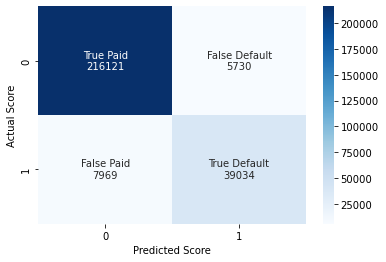

In [30]:
cbc_rs_fp = createConfusionMatrix(y_test_rs, y_pred)

### E. Feature Importance with Best Params

0:	learn: 0.5891192	total: 42.7ms	remaining: 42.6s
1:	learn: 0.5115581	total: 88.7ms	remaining: 44.3s
2:	learn: 0.4547759	total: 131ms	remaining: 43.4s
3:	learn: 0.4112727	total: 173ms	remaining: 43.2s
4:	learn: 0.3838239	total: 211ms	remaining: 41.9s
5:	learn: 0.3583699	total: 258ms	remaining: 42.8s
6:	learn: 0.3414740	total: 296ms	remaining: 42s
7:	learn: 0.3248483	total: 338ms	remaining: 41.9s
8:	learn: 0.3147457	total: 376ms	remaining: 41.4s
9:	learn: 0.3028447	total: 423ms	remaining: 41.9s
10:	learn: 0.2939229	total: 466ms	remaining: 41.9s
11:	learn: 0.2866692	total: 506ms	remaining: 41.7s
12:	learn: 0.2765952	total: 548ms	remaining: 41.6s
13:	learn: 0.2716714	total: 586ms	remaining: 41.3s
14:	learn: 0.2673750	total: 627ms	remaining: 41.2s
15:	learn: 0.2636391	total: 662ms	remaining: 40.7s
16:	learn: 0.2585425	total: 709ms	remaining: 41s
17:	learn: 0.2554375	total: 752ms	remaining: 41s
18:	learn: 0.2527816	total: 789ms	remaining: 40.7s
19:	learn: 0.2501683	total: 826ms	remaining: 

162:	learn: 0.1600939	total: 6.84s	remaining: 35.1s
163:	learn: 0.1600187	total: 6.88s	remaining: 35.1s
164:	learn: 0.1599330	total: 6.92s	remaining: 35s
165:	learn: 0.1598237	total: 6.96s	remaining: 35s
166:	learn: 0.1596826	total: 7s	remaining: 34.9s
167:	learn: 0.1594655	total: 7.04s	remaining: 34.9s
168:	learn: 0.1593631	total: 7.08s	remaining: 34.8s
169:	learn: 0.1592523	total: 7.12s	remaining: 34.8s
170:	learn: 0.1591394	total: 7.16s	remaining: 34.7s
171:	learn: 0.1589556	total: 7.21s	remaining: 34.7s
172:	learn: 0.1587968	total: 7.25s	remaining: 34.7s
173:	learn: 0.1587101	total: 7.29s	remaining: 34.6s
174:	learn: 0.1586108	total: 7.33s	remaining: 34.6s
175:	learn: 0.1585271	total: 7.37s	remaining: 34.5s
176:	learn: 0.1583968	total: 7.41s	remaining: 34.5s
177:	learn: 0.1582429	total: 7.46s	remaining: 34.4s
178:	learn: 0.1581342	total: 7.5s	remaining: 34.4s
179:	learn: 0.1579894	total: 7.54s	remaining: 34.4s
180:	learn: 0.1578947	total: 7.58s	remaining: 34.3s
181:	learn: 0.157788

321:	learn: 0.1462414	total: 13.6s	remaining: 28.5s
322:	learn: 0.1461751	total: 13.6s	remaining: 28.5s
323:	learn: 0.1461090	total: 13.7s	remaining: 28.5s
324:	learn: 0.1460765	total: 13.7s	remaining: 28.4s
325:	learn: 0.1460354	total: 13.7s	remaining: 28.4s
326:	learn: 0.1459915	total: 13.8s	remaining: 28.4s
327:	learn: 0.1459283	total: 13.8s	remaining: 28.3s
328:	learn: 0.1458885	total: 13.9s	remaining: 28.3s
329:	learn: 0.1458101	total: 13.9s	remaining: 28.2s
330:	learn: 0.1457286	total: 13.9s	remaining: 28.2s
331:	learn: 0.1456906	total: 14s	remaining: 28.1s
332:	learn: 0.1456298	total: 14s	remaining: 28.1s
333:	learn: 0.1455642	total: 14.1s	remaining: 28.1s
334:	learn: 0.1455183	total: 14.1s	remaining: 28s
335:	learn: 0.1454847	total: 14.1s	remaining: 28s
336:	learn: 0.1454469	total: 14.2s	remaining: 27.9s
337:	learn: 0.1453707	total: 14.2s	remaining: 27.9s
338:	learn: 0.1453447	total: 14.3s	remaining: 27.8s
339:	learn: 0.1453104	total: 14.3s	remaining: 27.8s
340:	learn: 0.145271

481:	learn: 0.1400994	total: 20.4s	remaining: 21.9s
482:	learn: 0.1400739	total: 20.4s	remaining: 21.9s
483:	learn: 0.1400507	total: 20.5s	remaining: 21.8s
484:	learn: 0.1400288	total: 20.5s	remaining: 21.8s
485:	learn: 0.1399785	total: 20.6s	remaining: 21.8s
486:	learn: 0.1399527	total: 20.6s	remaining: 21.7s
487:	learn: 0.1399306	total: 20.7s	remaining: 21.7s
488:	learn: 0.1399048	total: 20.7s	remaining: 21.6s
489:	learn: 0.1398827	total: 20.7s	remaining: 21.6s
490:	learn: 0.1398525	total: 20.8s	remaining: 21.5s
491:	learn: 0.1397934	total: 20.8s	remaining: 21.5s
492:	learn: 0.1397661	total: 20.9s	remaining: 21.5s
493:	learn: 0.1397380	total: 20.9s	remaining: 21.4s
494:	learn: 0.1396953	total: 21s	remaining: 21.4s
495:	learn: 0.1396751	total: 21s	remaining: 21.3s
496:	learn: 0.1396505	total: 21.1s	remaining: 21.3s
497:	learn: 0.1396371	total: 21.1s	remaining: 21.3s
498:	learn: 0.1396033	total: 21.1s	remaining: 21.2s
499:	learn: 0.1395742	total: 21.2s	remaining: 21.2s
500:	learn: 0.13

644:	learn: 0.1360276	total: 27.7s	remaining: 15.2s
645:	learn: 0.1360067	total: 27.7s	remaining: 15.2s
646:	learn: 0.1359840	total: 27.8s	remaining: 15.2s
647:	learn: 0.1359728	total: 27.8s	remaining: 15.1s
648:	learn: 0.1359463	total: 27.9s	remaining: 15.1s
649:	learn: 0.1359323	total: 27.9s	remaining: 15s
650:	learn: 0.1359037	total: 27.9s	remaining: 15s
651:	learn: 0.1358860	total: 28s	remaining: 14.9s
652:	learn: 0.1358668	total: 28s	remaining: 14.9s
653:	learn: 0.1358409	total: 28.1s	remaining: 14.9s
654:	learn: 0.1358242	total: 28.1s	remaining: 14.8s
655:	learn: 0.1358040	total: 28.2s	remaining: 14.8s
656:	learn: 0.1357879	total: 28.2s	remaining: 14.7s
657:	learn: 0.1357618	total: 28.2s	remaining: 14.7s
658:	learn: 0.1357446	total: 28.3s	remaining: 14.6s
659:	learn: 0.1357268	total: 28.3s	remaining: 14.6s
660:	learn: 0.1357145	total: 28.4s	remaining: 14.6s
661:	learn: 0.1356813	total: 28.4s	remaining: 14.5s
662:	learn: 0.1356674	total: 28.5s	remaining: 14.5s
663:	learn: 0.135653

804:	learn: 0.1330708	total: 34.5s	remaining: 8.36s
805:	learn: 0.1330629	total: 34.6s	remaining: 8.32s
806:	learn: 0.1330466	total: 34.6s	remaining: 8.27s
807:	learn: 0.1330179	total: 34.6s	remaining: 8.23s
808:	learn: 0.1330067	total: 34.7s	remaining: 8.19s
809:	learn: 0.1329966	total: 34.7s	remaining: 8.15s
810:	learn: 0.1329822	total: 34.8s	remaining: 8.11s
811:	learn: 0.1329681	total: 34.8s	remaining: 8.06s
812:	learn: 0.1329448	total: 34.9s	remaining: 8.02s
813:	learn: 0.1329353	total: 34.9s	remaining: 7.98s
814:	learn: 0.1329146	total: 35s	remaining: 7.93s
815:	learn: 0.1328912	total: 35s	remaining: 7.89s
816:	learn: 0.1328810	total: 35s	remaining: 7.85s
817:	learn: 0.1328674	total: 35.1s	remaining: 7.81s
818:	learn: 0.1328555	total: 35.1s	remaining: 7.76s
819:	learn: 0.1328362	total: 35.2s	remaining: 7.72s
820:	learn: 0.1328279	total: 35.2s	remaining: 7.68s
821:	learn: 0.1328119	total: 35.3s	remaining: 7.63s
822:	learn: 0.1327935	total: 35.3s	remaining: 7.59s
823:	learn: 0.1327

965:	learn: 0.1308242	total: 41.3s	remaining: 1.45s
966:	learn: 0.1308097	total: 41.4s	remaining: 1.41s
967:	learn: 0.1308012	total: 41.4s	remaining: 1.37s
968:	learn: 0.1307850	total: 41.4s	remaining: 1.32s
969:	learn: 0.1307752	total: 41.5s	remaining: 1.28s
970:	learn: 0.1307660	total: 41.5s	remaining: 1.24s
971:	learn: 0.1307449	total: 41.6s	remaining: 1.2s
972:	learn: 0.1307283	total: 41.6s	remaining: 1.15s
973:	learn: 0.1307143	total: 41.7s	remaining: 1.11s
974:	learn: 0.1307066	total: 41.7s	remaining: 1.07s
975:	learn: 0.1306955	total: 41.7s	remaining: 1.03s
976:	learn: 0.1306761	total: 41.8s	remaining: 984ms
977:	learn: 0.1306627	total: 41.8s	remaining: 941ms
978:	learn: 0.1306522	total: 41.9s	remaining: 898ms
979:	learn: 0.1306434	total: 41.9s	remaining: 856ms
980:	learn: 0.1306347	total: 42s	remaining: 813ms
981:	learn: 0.1306272	total: 42s	remaining: 770ms
982:	learn: 0.1306184	total: 42s	remaining: 727ms
983:	learn: 0.1306059	total: 42.1s	remaining: 684ms
984:	learn: 0.13059

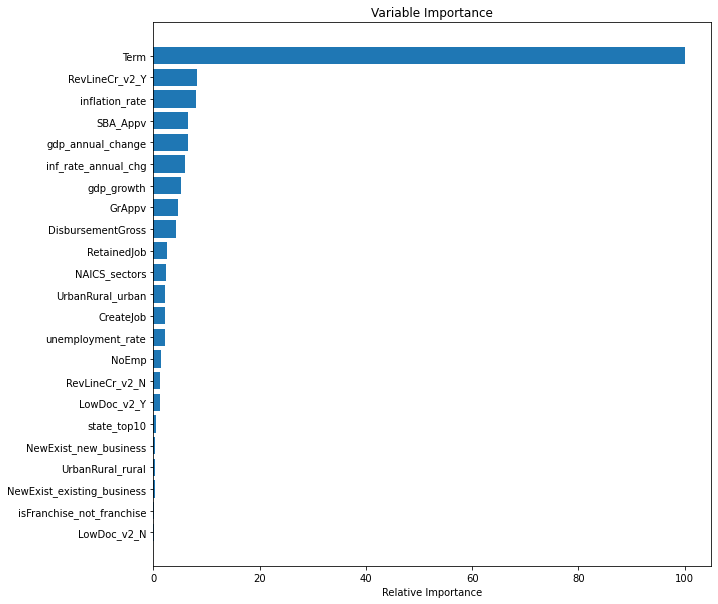

In [31]:
createFeatureImportanceChart(CatBoostClassifier, cbc_rs_best_params, features, X_train_rs, y_train_rs)

## 5. Best CatBoost Classifier Model

In [32]:
if cbc_ss_fp > cbc_rs_fp:
    print('Best Logistic Regression Model Params: {}'.format(cbc_rs_best_params))
    print('Best Scaler: Robust Scaler')
else:
    print('Best Logistic Regression Model Params: {}'.format(cbc_ss_best_params))
    print('Best Scaler: Standard Scaler')

Best Logistic Regression Model Params: {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 3.0, 'learning_rate': 0.1}
Best Scaler: Standard Scaler
